In [1]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import scipy as sp
from scipy import stats
from PIL import Image, ImageFilter
import time
from sklearn import metrics
import random
import pyspark
from pyspark.sql import SparkSession
from datetime import date, datetime

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
spark = SparkSession.builder.appName('Churn_Prediction').getOrCreate()

In [5]:
df_1 = spark.read.parquet("/content/drive/MyDrive/Colab Notebooks/Research_Project/DC_TEST.parquet")

In [6]:
df_1.show()

+--------+--------------------+-------------------+---------+--------------------+-----------+--------------------+---------------+--------------------+---------+---------------+---------------+------------+--------------------+----+----------------+--------------------+--------------------+----------+----------+-----------+-------------------+
|     CIF|          SHORT_NAME|      CUS_OPEN_DATE|SECTOR_ID|         SECTOR_NAME|INDUSTRY_ID|       INDUSTRY_NAME|SUB_INDUSTRY_ID|   SUB_INDUSTRY_NAME|TARGET_ID|    TARGET_NAME|ACCOUNT_OFFICER|COMPANY_BOOK|        COMPANY_NAME|PKKH|PKKH_DIEU_CHUYEN|PKKH_DIEU_CHUYEN_SUB|      ABB_STAND_CORP|BUCKET_ABB|INTRODUCER|COMPANY_VIP|           MIS_DATE|
+--------+--------------------+-------------------+---------+--------------------+-----------+--------------------+---------------+--------------------+---------+---------------+---------------+------------+--------------------+----+----------------+--------------------+--------------------+----------+---

In [7]:
df_2 = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/Research_Project/DIM_CUSTOMER_20240922.parquet')

In [8]:
df_2.show()

+-----------------+--------------------+-----------------------+------------+---------------+------------------+-------------------+---------------------+--------------------+-----------------+----------------+-------------------+-------------------+--------------------+----------------------+---------------------------+-------------------+-------------------+---------------+-------------+-------------------+-----------------+--------------------+-------------------+
|V_D_CUST_REF_CODE|N_D_CUST_JOINING_AGE|V_D_CUST_MARITAL_STATUS|N_D_CUST_AGE|V_D_CUST_GENDER|F_D_CUST_STAFF_IND|D_D_CUST_START_DATE|V_D_CUST_BUSS_SEGMENT|V_D_CUST_BRANCH_CODE|V_D_INDUSTRY_CODE|V_D_CUST_SEGMENT|D_RECORD_START_DATE|  D_RECORD_END_DATE|V_CUSTOMER_FULL_NAME|AV_BUSINESS_CLASS_CODE|AV_MAIN_BUSINESS_CLASS_CODE|    AD_CONTACT_DATE|       AD_DATE_TIME|AV_LOB_CODE_MAP|F_ACTIVE_FLAG|      D_ACTIVE_DATE|V_CUSTOMER_STATUS|D_SEGMENT_START_DATE| D_SEGMENT_END_DATE|
+-----------------+--------------------+----------------

In [9]:
df_2 = df_2.withColumnRenamed('V_D_CUST_REF_CODE', 'CIF')

In [10]:
df_1.count()

2258581

In [11]:
df_2.count()

2254442

In [12]:
df_2.printSchema()

root
 |-- CIF: string (nullable = true)
 |-- N_D_CUST_JOINING_AGE: double (nullable = true)
 |-- V_D_CUST_MARITAL_STATUS: string (nullable = true)
 |-- N_D_CUST_AGE: double (nullable = true)
 |-- V_D_CUST_GENDER: string (nullable = true)
 |-- F_D_CUST_STAFF_IND: string (nullable = true)
 |-- D_D_CUST_START_DATE: timestamp_ntz (nullable = true)
 |-- V_D_CUST_BUSS_SEGMENT: string (nullable = true)
 |-- V_D_CUST_BRANCH_CODE: string (nullable = true)
 |-- V_D_INDUSTRY_CODE: string (nullable = true)
 |-- V_D_CUST_SEGMENT: string (nullable = true)
 |-- D_RECORD_START_DATE: timestamp_ntz (nullable = true)
 |-- D_RECORD_END_DATE: timestamp_ntz (nullable = true)
 |-- V_CUSTOMER_FULL_NAME: string (nullable = true)
 |-- AV_BUSINESS_CLASS_CODE: string (nullable = true)
 |-- AV_MAIN_BUSINESS_CLASS_CODE: string (nullable = true)
 |-- AD_CONTACT_DATE: timestamp_ntz (nullable = true)
 |-- AD_DATE_TIME: timestamp_ntz (nullable = true)
 |-- AV_LOB_CODE_MAP: string (nullable = true)
 |-- F_ACTIVE_FLAG: s

In [13]:
df = df_1.join(df_2, on='CIF', how='inner')

In [14]:
df.printSchema()

root
 |-- CIF: string (nullable = true)
 |-- SHORT_NAME: string (nullable = true)
 |-- CUS_OPEN_DATE: timestamp_ntz (nullable = true)
 |-- SECTOR_ID: string (nullable = true)
 |-- SECTOR_NAME: string (nullable = true)
 |-- INDUSTRY_ID: string (nullable = true)
 |-- INDUSTRY_NAME: string (nullable = true)
 |-- SUB_INDUSTRY_ID: string (nullable = true)
 |-- SUB_INDUSTRY_NAME: string (nullable = true)
 |-- TARGET_ID: string (nullable = true)
 |-- TARGET_NAME: string (nullable = true)
 |-- ACCOUNT_OFFICER: string (nullable = true)
 |-- COMPANY_BOOK: string (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- PKKH: string (nullable = true)
 |-- PKKH_DIEU_CHUYEN: string (nullable = true)
 |-- PKKH_DIEU_CHUYEN_SUB: string (nullable = true)
 |-- ABB_STAND_CORP: string (nullable = true)
 |-- BUCKET_ABB: string (nullable = true)
 |-- INTRODUCER: string (nullable = true)
 |-- COMPANY_VIP: string (nullable = true)
 |-- MIS_DATE: timestamp_ntz (nullable = true)
 |-- N_D_CUST_JOINING_A

In [15]:
df.count()

2254389

In [16]:
df.show(20)

+--------+--------------------+-------------------+---------+--------------------+-----------+--------------------+---------------+--------------------+---------+---------------+---------------+------------+--------------------+----+----------------+--------------------+--------------------+----------+----------+-----------+-------------------+--------------------+-----------------------+------------+---------------+------------------+-------------------+---------------------+--------------------+-----------------+----------------+-------------------+-------------------+--------------------+----------------------+---------------------------+-------------------+-------------------+---------------+-------------+-------------------+-----------------+--------------------+-------------------+
|     CIF|          SHORT_NAME|      CUS_OPEN_DATE|SECTOR_ID|         SECTOR_NAME|INDUSTRY_ID|       INDUSTRY_NAME|SUB_INDUSTRY_ID|   SUB_INDUSTRY_NAME|TARGET_ID|    TARGET_NAME|ACCOUNT_OFFICER|COMPANY

In [17]:
column_mapping = {
    'CIF': "customer_id",
    'SHORT_NAME': "short_name",
    "CUS_OPEN_DATE": "customer_open_date",
    "SECTOR_ID": "sector_id",
    "SECTOR_NAME": "sector_name",
    "INDUSTRY_ID": "industry_id",
    "INDUSTRY_NAME": "industry_name",
    "SUB_INDUSTRY_ID": "sub_industry_id",
    "SUB_INDUSTRY_NAME": "sub_industry_name",
    "TARGET_ID": "target_id",
    "TARGET_NAME": "target_name",
    "ACOUNT_OFFICER": "account_officer",
    "COMPANY_BOOK": "company_book",
    "COMPANY_NAME": "company_name",
    "PKKH": "customer_level",
    "PKKH_DIEU_CHUYEN": "customer_level_change",
    "PKKH_DIEU_CHUYEN_SUB": "sub_customer_level_change",
    "ABB_STAND_CORP": "standardized_corp_level",
    "BUCKET_ABB": "bucket_abb",
    "INTRODUCER": "introducer",
    "COMPANY_VIP": "company_vip",
    "MIS_DATE": "mis_date",
    "N_D_CUST_JOINING_AGE": "customer_joining_age",
    "V_D_CUST_MARITAL_STATUS": "marital_status",
    "N_D_CUST_AGE": "customer_age",
    "V_D_CUST_GENDER": "gender",
    "F_D_CUST_STAFF_IND": "staff_indicator",
    "D_D_CUST_START_DATE": "customer_start_date",
    "V_D_CUST_BUSS_SEGMENT": "business_segment",
    "V_D_CUST_BRANCH_CODE": "branch_code",
    "V_D_INDUSTRY_CODE": "industry_code",
    "V_D_CUST_SEGMENT": "customer_segment",
    "D_RECORD_START_DATE": "record_start_date",
    "D_RECORD_END_DATE": "record_end_date",
    "V_CUSTOMER_FULL_NAME": "full_name",
    "AV_BUSINESS_CLASS_CODE": "business_class_code",
    "AV_MAIN_BUSINESS_CLASS_CODE": "main_business_class_code",
    "AD_CONTACT_DATE": "contact_date",
    "AD_DATE_TIME": "contact_time",
    "AV_LOB_CODE_MAP": "lob_code_map",
    "F_ACTIVE_FLAG": "churn",
    "D_ACTIVE_DATE": "active_date",
    "V_CUSTOMER_STATUS": "customer_status",
    "D_SEGMENT_START_DATE": "segment_start_date",
    "D_SEGMENT_END_DATE": "segment_end_date",
    'ACCOUNT_OFFICER': 'account_officer',

}
for old_name, new_name in column_mapping.items():
    df = df.withColumnRenamed(old_name, new_name)

In [18]:
df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- customer_open_date: timestamp_ntz (nullable = true)
 |-- sector_id: string (nullable = true)
 |-- sector_name: string (nullable = true)
 |-- industry_id: string (nullable = true)
 |-- industry_name: string (nullable = true)
 |-- sub_industry_id: string (nullable = true)
 |-- sub_industry_name: string (nullable = true)
 |-- target_id: string (nullable = true)
 |-- target_name: string (nullable = true)
 |-- account_officer: string (nullable = true)
 |-- company_book: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- customer_level: string (nullable = true)
 |-- customer_level_change: string (nullable = true)
 |-- sub_customer_level_change: string (nullable = true)
 |-- standardized_corp_level: string (nullable = true)
 |-- bucket_abb: string (nullable = true)
 |-- introducer: string (nullable = true)
 |-- company_vip: string (nullable = true)
 |-- mis_date: timestamp_ntz

In [21]:
from pyspark.sql.functions import col, count, when, countDistinct

In [22]:
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

+-----------+----------+------------------+---------+-----------+-----------+-------------+---------------+-----------------+---------+-----------+---------------+------------+------------+--------------+---------------------+-------------------------+-----------------------+----------+----------+-----------+--------+--------------------+--------------+------------+------+---------------+-------------------+----------------+-----------+-------------+----------------+-----------------+---------------+---------+-------------------+------------------------+------------+------------+------------+-------+-----------+---------------+------------------+----------------+
|customer_id|short_name|customer_open_date|sector_id|sector_name|industry_id|industry_name|sub_industry_id|sub_industry_name|target_id|target_name|account_officer|company_book|company_name|customer_level|customer_level_change|sub_customer_level_change|standardized_corp_level|bucket_abb|introducer|company_vip|mis_date|customer_

In [23]:
distinct_counts = df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns))

In [24]:
distinct_counts.show()

+-----------+----------+------------------+---------+-----------+-----------+-------------+---------------+-----------------+---------+-----------+---------------+------------+------------+--------------+---------------------+-------------------------+-----------------------+----------+----------+-----------+--------+--------------------+--------------+------------+------+---------------+-------------------+----------------+-----------+-------------+----------------+-----------------+---------------+---------+-------------------+------------------------+------------+------------+------------+-----+-----------+---------------+------------------+----------------+
|customer_id|short_name|customer_open_date|sector_id|sector_name|industry_id|industry_name|sub_industry_id|sub_industry_name|target_id|target_name|account_officer|company_book|company_name|customer_level|customer_level_change|sub_customer_level_change|standardized_corp_level|bucket_abb|introducer|company_vip|mis_date|customer_jo

In [25]:
df = df.drop('sub_industry_id', 'sub_industry_name', 'standardized_corp_level', 'introducer', 'company_vip', 'active_date')

In [26]:
df.describe().show()

+-------+--------------------+--------------------+------------------+--------------------+-----------------+--------------------+------------------+-----------+------------------+------------+--------------------+--------------+---------------------+-------------------------+-------------------+--------------------+--------------+------------------+-------+---------------+------------------+-----------+-----------------+----------------+--------------------+-------------------+------------------------+------------+------+----------------+
|summary|         customer_id|          short_name|         sector_id|         sector_name|      industry_id|       industry_name|         target_id|target_name|   account_officer|company_book|        company_name|customer_level|customer_level_change|sub_customer_level_change|         bucket_abb|customer_joining_age|marital_status|      customer_age| gender|staff_indicator|  business_segment|branch_code|    industry_code|customer_segment|           f

In [27]:
df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- customer_open_date: timestamp_ntz (nullable = true)
 |-- sector_id: string (nullable = true)
 |-- sector_name: string (nullable = true)
 |-- industry_id: string (nullable = true)
 |-- industry_name: string (nullable = true)
 |-- target_id: string (nullable = true)
 |-- target_name: string (nullable = true)
 |-- account_officer: string (nullable = true)
 |-- company_book: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- customer_level: string (nullable = true)
 |-- customer_level_change: string (nullable = true)
 |-- sub_customer_level_change: string (nullable = true)
 |-- bucket_abb: string (nullable = true)
 |-- mis_date: timestamp_ntz (nullable = true)
 |-- customer_joining_age: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- customer_age: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- staff_indicator: string (nullabl

In [29]:
from pyspark.sql.functions import col, count, when, countDistinct, unix_timestamp, from_unixtime, lit
df = df.fillna({'churn': '1'})
df = df.withColumn('churn', when(df['churn'] == 'Y', lit(0)).otherwise(df['churn']))

In [30]:
target_df = df.select('churn').toPandas()

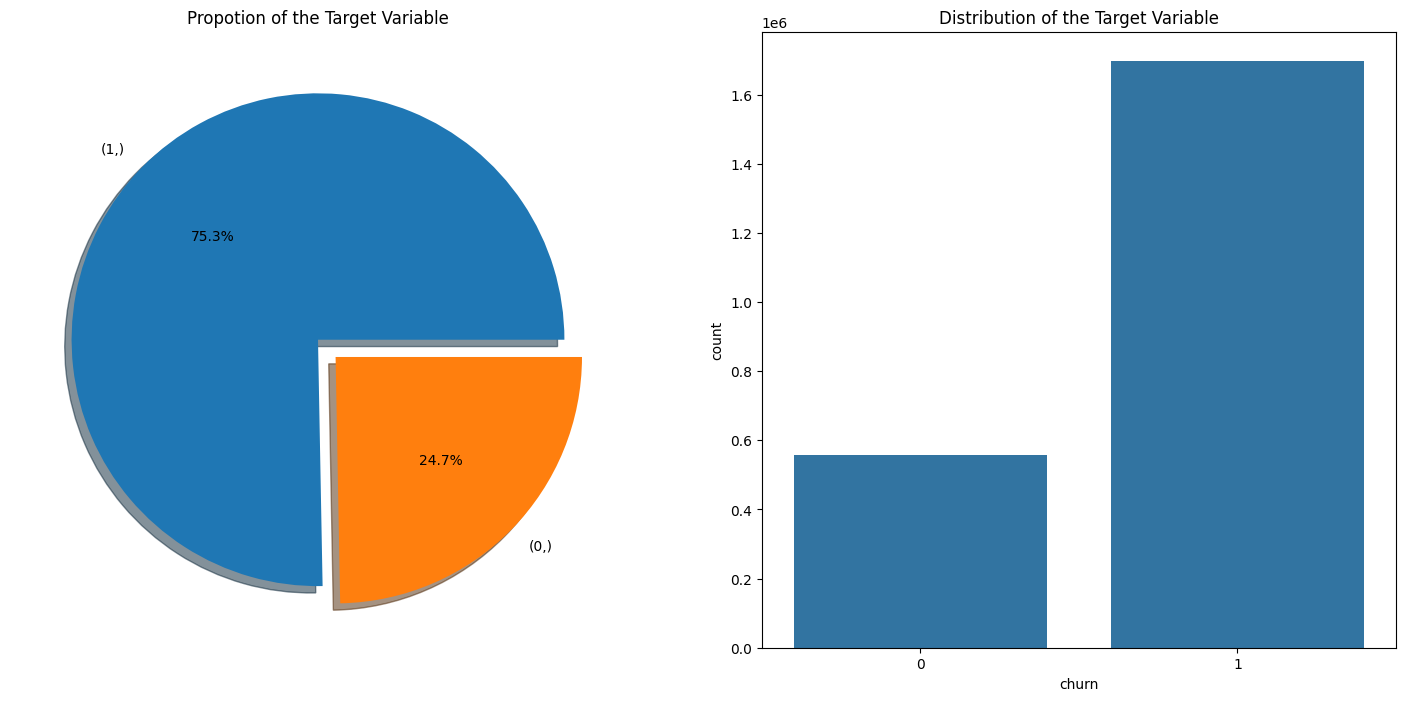

In [31]:
f,ax = plt.subplots(1,2, figsize=(18,8))
target_df.value_counts().plot.pie(explode=[0,0.1],autopct = "%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title('Propotion of the Target Variable')
ax[0].set_ylabel('')
sns.countplot(x = 'churn', data=target_df, ax=ax[1])
ax[1].set_title('Distribution of the Target Variable')
plt.show()

In [32]:
from pyspark.sql.functions import col, mean, stddev, min, max
age_stats = df.select(
    mean(col("customer_age")).alias("Mean Age"),
    stddev(col("customer_age")).alias("Standard Deviation"),
    min(col("customer_age")).alias("Minimum Age"),
    max(col("customer_age")).alias("Maximum Age")
)

In [33]:
age_stats.show()

+-----------------+------------------+-----------+-----------+
|         Mean Age|Standard Deviation|Minimum Age|Maximum Age|
+-----------------+------------------+-----------+-----------+
|39.14947307249082|14.932591409527253|        0.0|     1024.0|
+-----------------+------------------+-----------+-----------+



In [34]:
quantiles = df.approxQuantile("customer_age", [0.25, 0.5, 0.75], 0.01)
quantiles_dict = {
    "25%": quantiles[0],
    "Median (50%)": quantiles[1],
    "75%": quantiles[2]
}

quantiles_dict

{'25%': 29.0, 'Median (50%)': 37.0, '75%': 48.0}

In [35]:
age_df = df.select("customer_age", "customer_joining_age").toPandas()
age_df.head()

,customer_age,customer_joining_age
0,23.0,22.0
1,35.0,34.0
2,40.0,40.0
3,22.0,22.0
4,29.0,29.0


In [36]:
age_df_filtered = age_df[(age_df["customer_age"] <= 122) & (age_df["customer_joining_age"] <= 122)]
age_df_filtered.head()

,customer_age,customer_joining_age
0,23.0,22.0
1,35.0,34.0
2,40.0,40.0
3,22.0,22.0
4,29.0,29.0


In [37]:
def summarize_numeric_column(df, column, show_plots=False, bins=20, percentiles=None, figsize=(12, 10), palette='Set2'):

    if percentiles is None:
        percentiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(f"Summary Statistics for '{column}':")
    print("##########################################")
    print(df[column].describe(percentiles=percentiles).T)
    print("##########################################\n")

    if show_plots:
        sns.set(style="whitegrid", palette=palette)

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f"Visualizations for '{column}'", fontsize=16)

        # Histogram
        sns.histplot(df[column], bins=bins, kde=False, ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title(f"{column} Distribution")
        axes[0, 0].set_xlabel(column)

        # Boxplot
        sns.boxplot(y=df[column], ax=axes[0, 1], color='lightgreen')
        axes[0, 1].set_title(f"Boxplot of {column}")
        axes[0, 1].set_ylabel('')

        # Density Plot
        sns.kdeplot(df[column], fill=True, ax=axes[1, 0], color='salmon')
        axes[1, 0].set_title(f"{column} Density Plot")
        axes[1, 0].set_xlabel(column)

        # QQ Plot
        stats.probplot(df[column], dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title(f"{column} QQ Plot")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

Summary Statistics for 'customer_age':
##########################################
count    2.226408e+06
mean     3.912011e+01
std      1.436409e+01
min      0.000000e+00
5%       2.000000e+01
10%      2.200000e+01
20%      2.700000e+01
30%      3.100000e+01
40%      3.400000e+01
50%      3.700000e+01
60%      4.100000e+01
70%      4.500000e+01
80%      5.100000e+01
90%      6.000000e+01
95%      6.600000e+01
99%      7.600000e+01
max      1.220000e+02
Name: customer_age, dtype: float64
##########################################



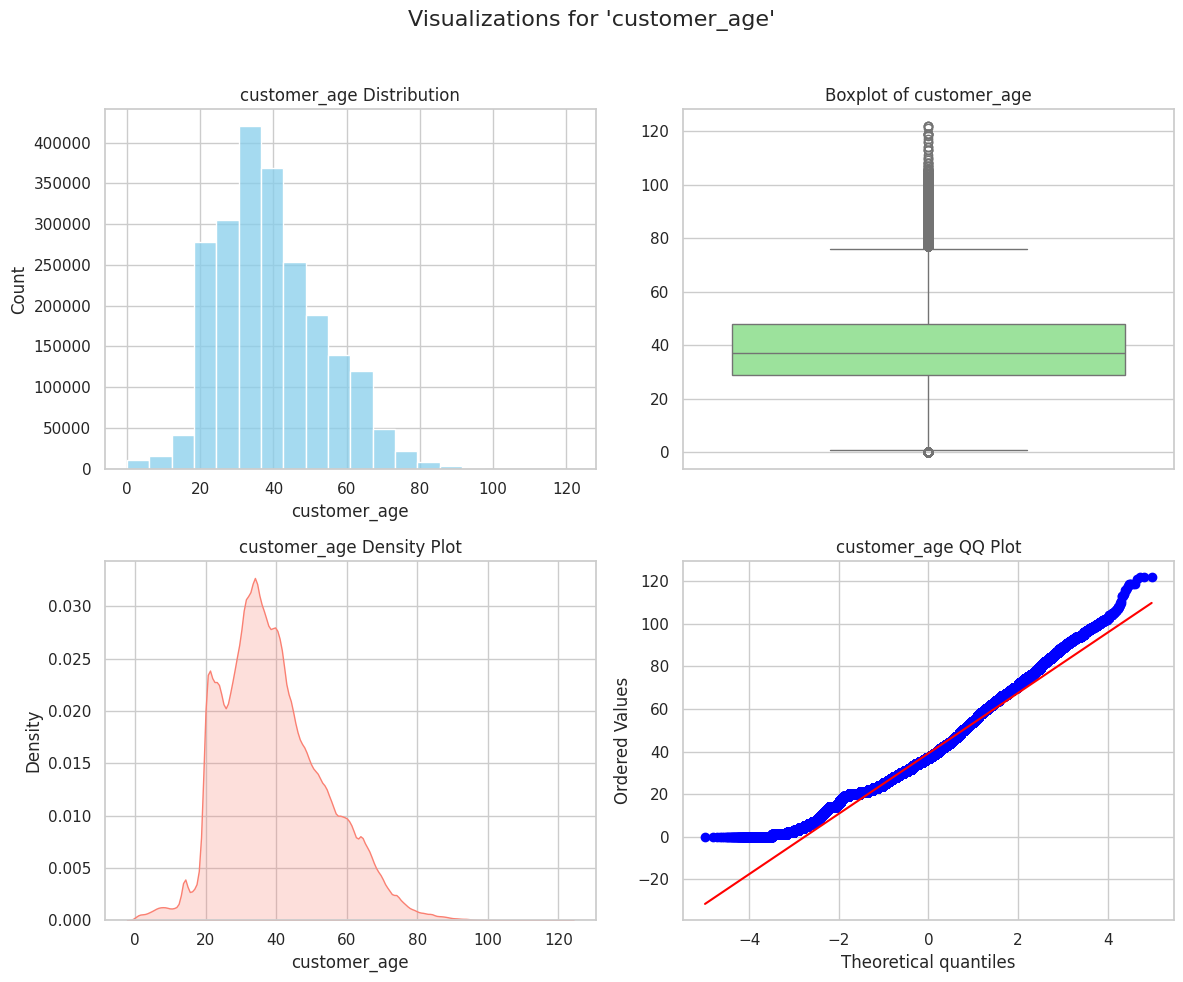

In [38]:
summarize_numeric_column(age_df_filtered, 'customer_age', show_plots=True)

Summary Statistics for 'customer_joining_age':
##########################################
count    2.226408e+06
mean     3.361938e+01
std      1.382720e+01
min     -1.700000e+01
5%       1.800000e+01
10%      1.900000e+01
20%      2.200000e+01
30%      2.500000e+01
40%      2.800000e+01
50%      3.100000e+01
60%      3.500000e+01
70%      3.900000e+01
80%      4.500000e+01
90%      5.300000e+01
95%      5.900000e+01
99%      7.000000e+01
max      1.190000e+02
Name: customer_joining_age, dtype: float64
##########################################



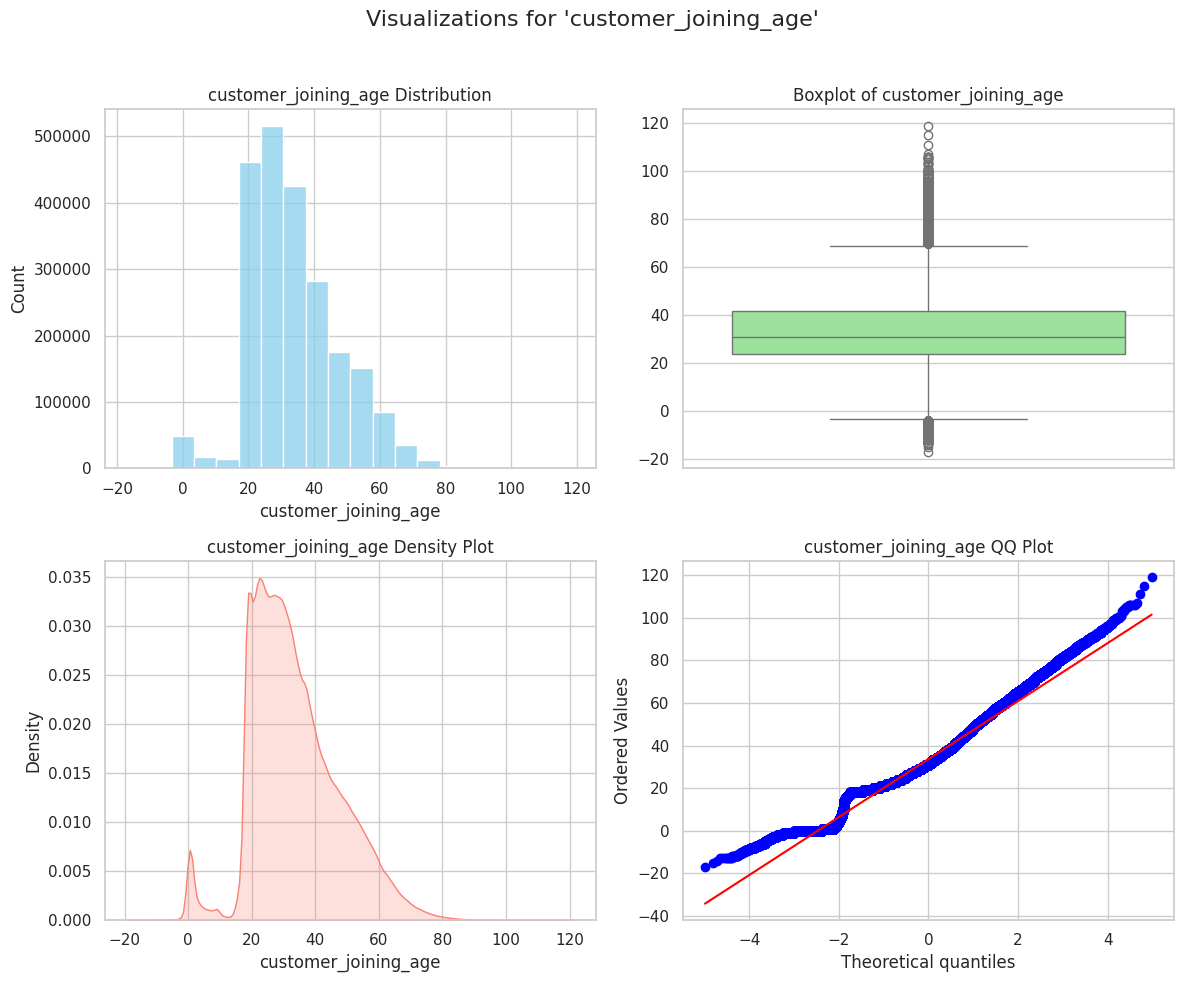

In [39]:
summarize_numeric_column(age_df_filtered, 'customer_joining_age', show_plots=True)

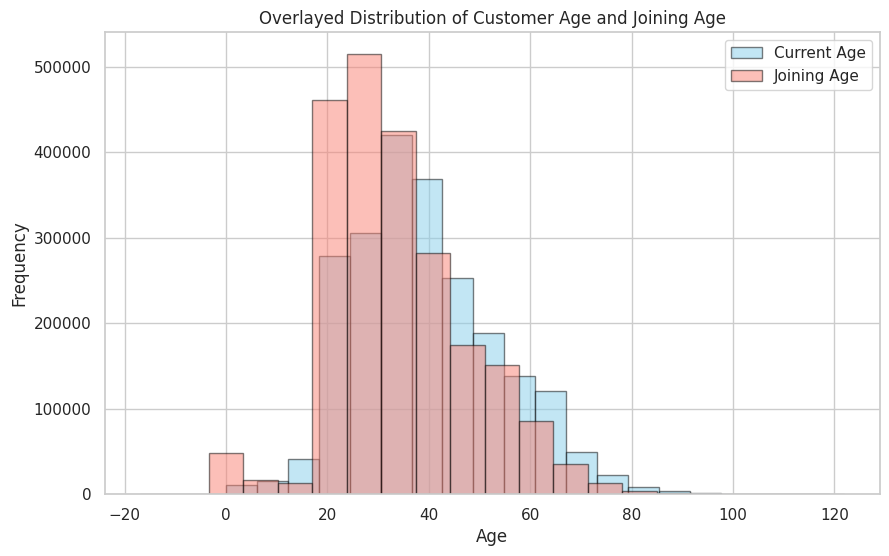

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(age_df_filtered['customer_age'], bins=20, color='skyblue', edgecolor='black', alpha=0.5, label='Current Age')
plt.hist(age_df_filtered['customer_joining_age'], bins=20, color='salmon', edgecolor='black', alpha=0.5, label='Joining Age')
plt.title("Overlayed Distribution of Customer Age and Joining Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [41]:
df.select('gender').distinct().show()
df.groupBy('gender').count().orderBy("count", ascending=False).show()

+------+
|gender|
+------+
|  MALE|
|FEMALE|
|  NULL|
+------+

+------+-------+
|gender|  count|
+------+-------+
|  MALE|1179276|
|FEMALE| 998956|
|  NULL|  76157|
+------+-------+



<Axes: title={'center': 'Gender Distribution'}, xlabel='gender'>

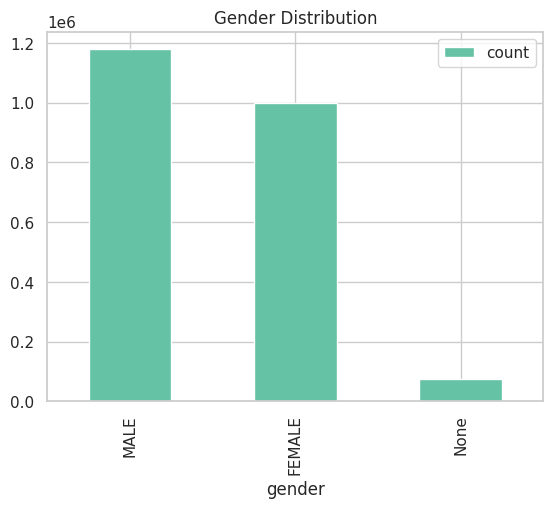

In [42]:
gender_dist = df.groupBy('gender').count().orderBy("count", ascending=False).toPandas()
gender_dist.plot(kind='bar', x='gender', y='count', title='Gender Distribution')

In [47]:
df = df.withColumn(
    "marital_status",
    when(df["marital_status"] == "MARRIED", True).otherwise(False)
)

In [48]:
df.select('marital_status').distinct().show()
df.groupBy('marital_status').count().orderBy("count", ascending=False).show()

+--------------+
|marital_status|
+--------------+
|          true|
|         false|
+--------------+

+--------------+-------+
|marital_status|  count|
+--------------+-------+
|         false|2050499|
|          true| 203890|
+--------------+-------+



<Axes: title={'center': 'Marital Status Distribution'}, xlabel='marital_status'>

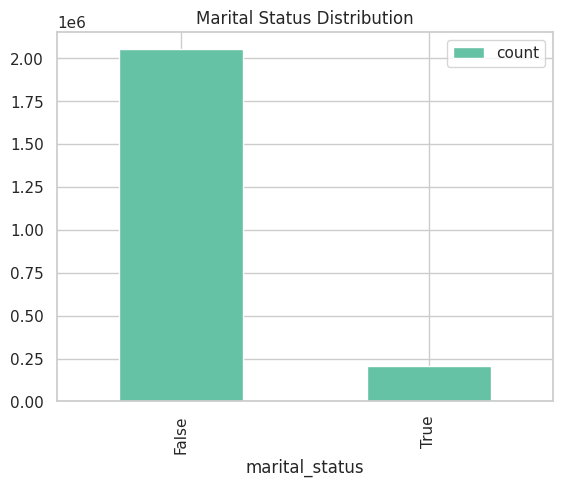

In [50]:
marital_status_dist = df.groupBy('marital_status').count().orderBy("count", ascending=False).toPandas()
marital_status_dist.plot(kind='bar', x='marital_status', y='count', title='Marital Status Distribution')

In [44]:
from pyspark.sql import functions as F
from datetime import datetime

today = datetime.now()
df = df.withColumn("tenure_years", F.round(F.datediff(F.lit(today), F.col("customer_open_date")) / 365.25, 2))

In [45]:
tenure_df = df.select("tenure_years").toPandas()

Summary Statistics for 'tenure_years':
##########################################
count    2.251016e+06
mean     5.960350e+00
std      4.911282e+00
min      1.500000e-01
5%       8.700000e-01
10%      1.510000e+00
20%      1.800000e+00
30%      2.030000e+00
40%      2.320000e+00
50%      3.850000e+00
60%      5.990000e+00
70%      8.220000e+00
80%      1.134000e+01
90%      1.397000e+01
95%      1.535000e+01
99%      1.722000e+01
max      7.620000e+01
Name: tenure_years, dtype: float64
##########################################



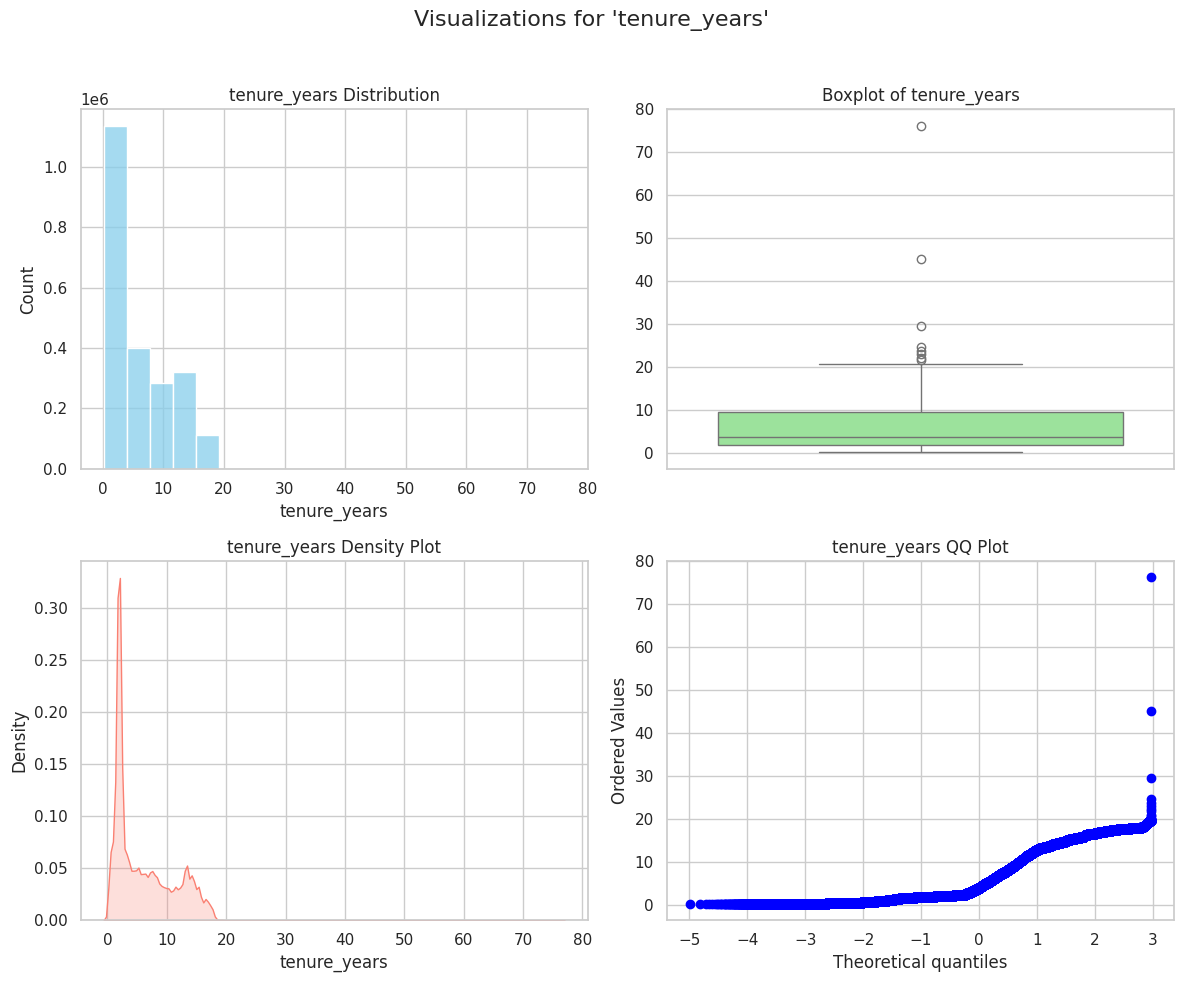

In [46]:
summarize_numeric_column(tenure_df, 'tenure_years', show_plots=True)

In [53]:
df = df.withColumn(
    "lifecycle_stage",
    F.when(F.col("tenure_years") <= 1, "New")
    .when((F.col("tenure_years") > 1) & (F.col("tenure_years") <= 5), "Early")
    .when((F.col("tenure_years") > 5) & (F.col("tenure_years") <= 10), "Established")
    .otherwise("Loyal")
)

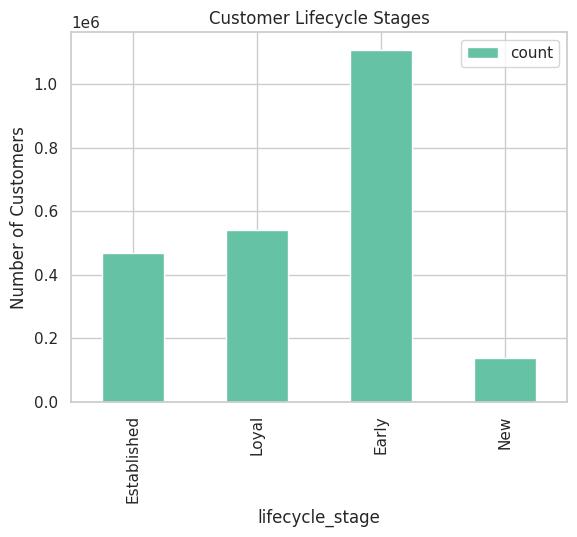

In [54]:
lifecycle_stage_dist = df.groupBy("lifecycle_stage").count().toPandas()
lifecycle_stage_dist.plot(kind='bar', x='lifecycle_stage', y='count', title='Customer Lifecycle Stages')
plt.ylabel("Number of Customers")
plt.show()

In [56]:
cust_segment_dist = df.groupBy('customer_segment').count().orderBy("count", ascending=False).toPandas()

In [57]:
buss_segment_dist = df.groupBy("business_segment").count().orderBy("count", ascending=False).toPandas()

In [58]:
cust_segment_dist["customer_segment"] = cust_segment_dist["customer_segment"].fillna("Unknown")

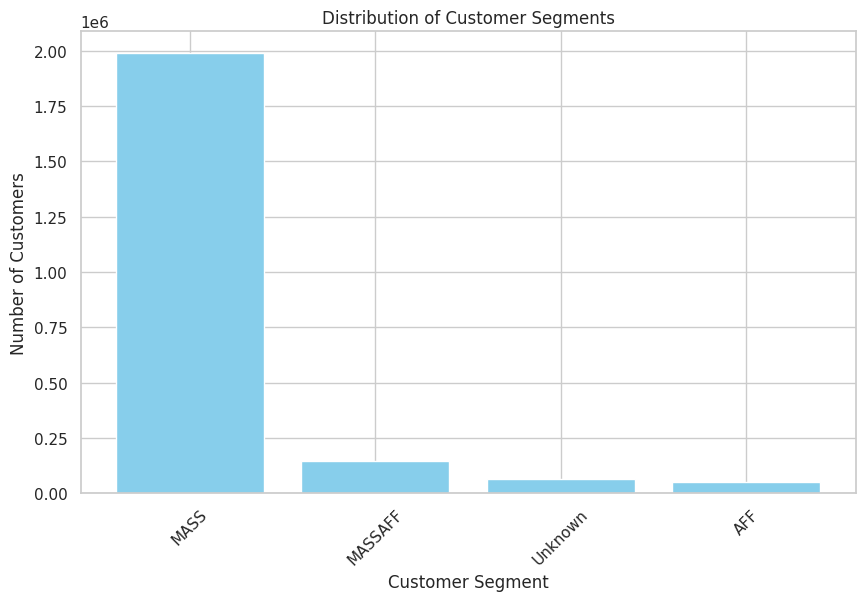

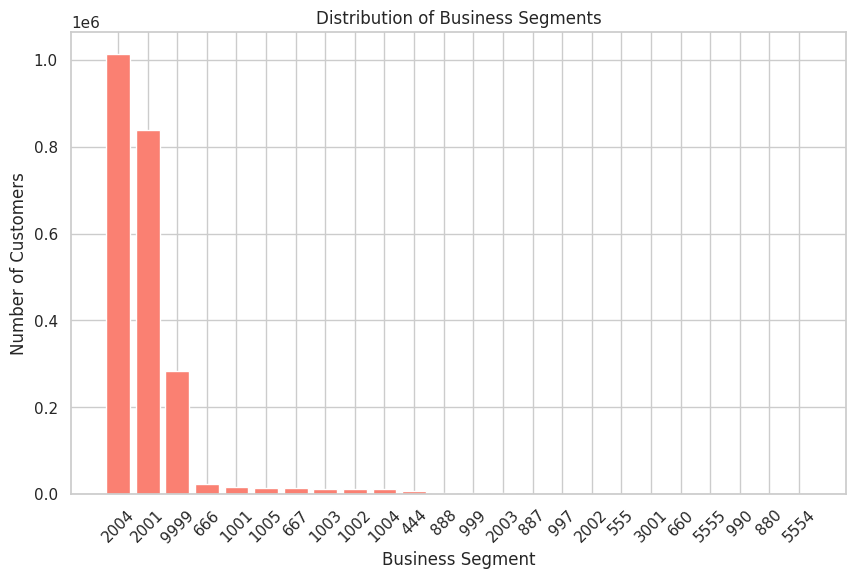

In [59]:
plt.figure(figsize=(10, 6))
plt.bar(cust_segment_dist["customer_segment"], cust_segment_dist["count"], color='skyblue')
plt.title("Distribution of Customer Segments")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(buss_segment_dist["business_segment"], buss_segment_dist["count"], color='salmon')
plt.title("Distribution of Business Segments")
plt.xlabel("Business Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()

In [60]:
df.select('sector_name').distinct().show()
df.groupBy('sector_name').count().orderBy("count", ascending=False).show()

+--------------------+
|         sector_name|
+--------------------+
|Quy tin dung nhan...|
|     ***Doanh Nghiep|
|Cong ty co phan (...|
|Cty Nha nuoc/Tong...|
|      To chuc xa hoi|
|Ngan hang chinh sach|
|       Nhan vien EVN|
|Cty TNHH 01 thanh...|
|Cty TNHH 01 thanh...|
|Cty TNHH 2TV von ...|
|      ***Individuals|
|        Chu DNTN DNL|
|Cty TNHH 01 thanh...|
|Cty TNHH 2TV von ...|
|Cac don vi truc t...|
|Chinh quyen trung...|
|Cac to chuc quoc ...|
|Quy dau tu - Cong...|
|Ngan hang phat trien|
|Chu DNTN (Nha tha...|
+--------------------+
only showing top 20 rows

+--------------------+-------+
|         sector_name|  count|
+--------------------+-------+
|             Ca nhan|2168368|
|   Cong ty TNHH SMEs|  24673|
|       Nhan vien EVN|  17921|
|Cong ty co phan SMEs|  12812|
|Chi nhanh NH nuoc...|  12578|
|    Nhan vien ABBANK|   3305|
|        Cong ty TNHH|   3098|
|Cty TNHH 01 thanh...|   2573|
|     Cong ty co phan|   1889|
|Doanh nghiep tu nhan|   1206|
|       Chu DNTN SM

In [61]:
df = df.filter(df["sector_name"] == "Ca nhan")

In [62]:
df = df.filter(df["industry_name"] == "X0000. Tu nhan")
df.show()

+-----------+--------------------+-------------------+---------+-----------+-----------+--------------+---------+---------------+---------------+------------+--------------------+--------------+---------------------+-------------------------+----------+-------------------+--------------------+--------------+------------+------+---------------+-------------------+----------------+-----------+-------------+----------------+-------------------+-------------------+--------------------+-------------------+------------------------+-------------------+-------------------+------------+-----+---------------+-------------------+-------------------+------------+---------------+
|customer_id|          short_name| customer_open_date|sector_id|sector_name|industry_id| industry_name|target_id|    target_name|account_officer|company_book|        company_name|customer_level|customer_level_change|sub_customer_level_change|bucket_abb|           mis_date|customer_joining_age|marital_status|customer_age|ge

In [63]:
distinct_counts = df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns))
distinct_counts.show()

+-----------+----------+------------------+---------+-----------+-----------+-------------+---------+-----------+---------------+------------+------------+--------------+---------------------+-------------------------+----------+--------+--------------------+--------------+------------+------+---------------+-------------------+----------------+-----------+-------------+----------------+-----------------+---------------+---------+-------------------+------------------------+------------+------------+------------+-----+---------------+------------------+----------------+------------+---------------+
|customer_id|short_name|customer_open_date|sector_id|sector_name|industry_id|industry_name|target_id|target_name|account_officer|company_book|company_name|customer_level|customer_level_change|sub_customer_level_change|bucket_abb|mis_date|customer_joining_age|marital_status|customer_age|gender|staff_indicator|customer_start_date|business_segment|branch_code|industry_code|customer_segment|reco

In [65]:
df = df.drop('sector_id', 'sector_name', 'customer_level', 'customer_level_change', 'mis_date', 'record_end_date', 'lob_code_map', 'industry_code',
             'industry_id', 'industry_name', 'target_id', 'branch_code', 'business_segment', 'sub_customer_level_change', 'short_name',
             'full_name', 'staff_indicator', 'account_officer', 'company_name', 'main_business_class_code')
df.show()

+-----------+-------------------+---------------+------------+----------+--------------------+--------------+------------+------+-------------------+----------------+-------------------+-------------------+------------------------+-------------------+-------------------+-----+---------------+-------------------+-------------------+------------+---------------+
|customer_id| customer_open_date|    target_name|company_book|bucket_abb|customer_joining_age|marital_status|customer_age|gender|customer_start_date|customer_segment|  record_start_date|business_class_code|main_business_class_code|       contact_date|       contact_time|churn|customer_status| segment_start_date|   segment_end_date|tenure_years|lifecycle_stage|
+-----------+-------------------+---------------+------------+----------+--------------------+--------------+------------+------+-------------------+----------------+-------------------+-------------------+------------------------+-------------------+-------------------+---

In [66]:
bucket_abb_counts = df.groupBy('bucket_abb').count().orderBy("count", ascending=False).toPandas()

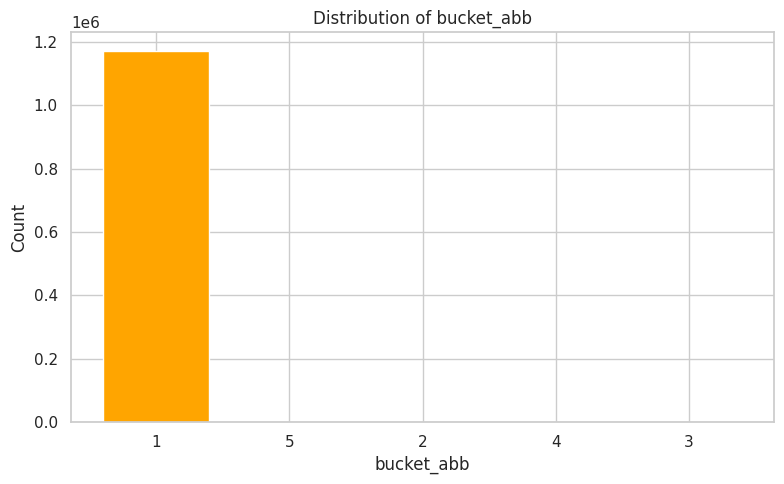

In [67]:
plt.figure(figsize=(8, 5))
plt.bar(bucket_abb_counts["bucket_abb"], bucket_abb_counts["count"], color='orange')
plt.title("Distribution of bucket_abb")
plt.xlabel("bucket_abb")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [68]:
df.groupBy('bucket_abb').count().orderBy("count", ascending=False).show()

+----------+-------+
|bucket_abb|  count|
+----------+-------+
|         1|1171242|
|         5|    272|
|         2|     50|
|         4|     36|
|         3|     22|
+----------+-------+



In [69]:
target_name_counts = df.groupBy("target_name").count().orderBy("count", ascending=False).toPandas()

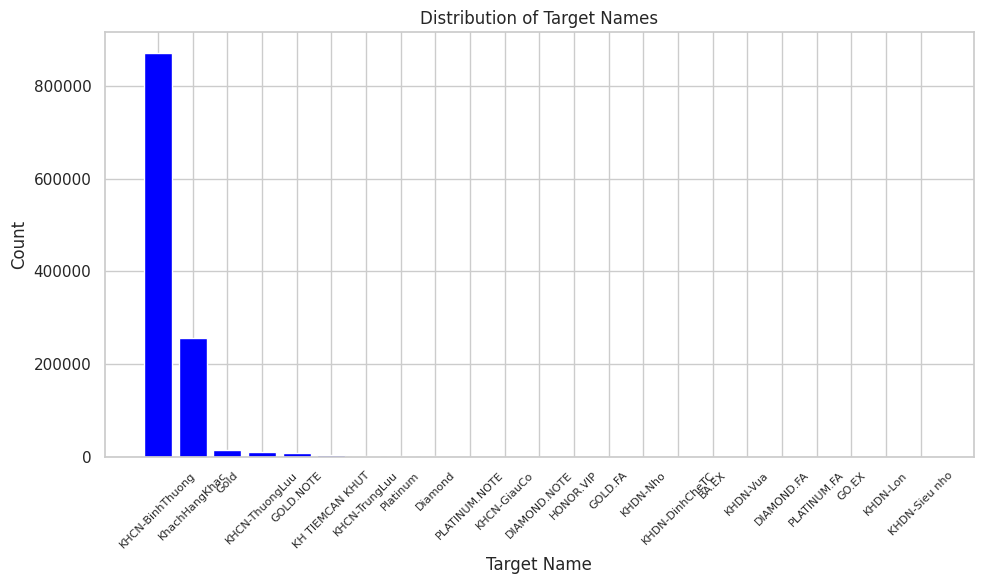

In [70]:
plt.figure(figsize=(10, 6))
plt.bar(target_name_counts["target_name"], target_name_counts["count"], color='blue')
plt.title("Distribution of Target Names")
plt.xlabel("Target Name")
plt.ylabel("Count")
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

In [71]:
df.groupBy("target_name").count().orderBy("count", ascending=False).show()

+---------------+------+
|    target_name| count|
+---------------+------+
|KHCN-BinhThuong|871939|
|  KhachHangKhac|257616|
|           Gold| 14822|
| KHCN-ThuongLuu|  9747|
|      GOLD.NOTE|  7828|
|KH TIEMCAN KHUT|  4799|
|  KHCN-TrungLuu|  1400|
|       Platinum|  1364|
|        Diamond|  1106|
|  PLATINUM.NOTE|   239|
|    KHCN-GiauCo|   239|
|   DIAMOND.NOTE|   175|
|      HONOR.VIP|   173|
|        GOLD.FA|    51|
|       KHDN-Nho|    46|
| KHDN-DinhCheTC|    28|
|          BA.EX|    26|
|       KHDN-Vua|    10|
|     DIAMOND.FA|     6|
|    PLATINUM.FA|     5|
+---------------+------+
only showing top 20 rows



In [72]:
df.select('customer_segment').distinct().show()
df.groupBy('customer_segment').count().orderBy("count", ascending=False).show()

+----------------+
|customer_segment|
+----------------+
|            MASS|
|         MASSAFF|
|             AFF|
|            NULL|
+----------------+

+----------------+-------+
|customer_segment|  count|
+----------------+-------+
|            MASS|1042390|
|         MASSAFF|  95674|
|             AFF|  31357|
|            NULL|   2201|
+----------------+-------+



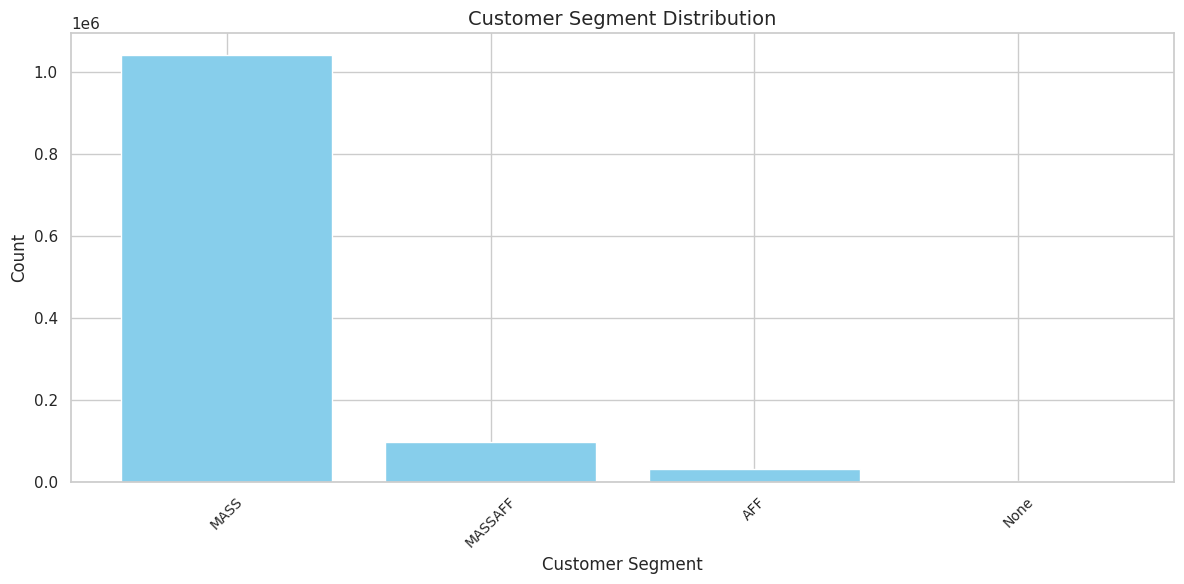

In [73]:
segment_dist = df.groupBy('customer_segment').count().orderBy('count', ascending=False)

segment_dist_pd = segment_dist.toPandas()

segment_dist_pd['customer_segment'] = segment_dist_pd['customer_segment'].astype(str)

plt.figure(figsize=(12, 6))
plt.bar(segment_dist_pd['customer_segment'], segment_dist_pd['count'], color='skyblue')
plt.title('Customer Segment Distribution', fontsize=14)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [76]:
import pyspark.sql.functions as F

df_with_duration = df.withColumn(
    "segment_duration_days",
    F.datediff(F.col("segment_start_date"), F.col("segment_end_date"))
)

segment_duration_stats = df_with_duration.groupBy("customer_segment").agg(
    F.count("customer_id").alias("Customer_Count"),
    F.avg("segment_duration_days").alias("Avg_Segment_Duration_Days"),
    F.min("segment_duration_days").alias("Min_Segment_Duration_Days"),
    F.max("segment_duration_days").alias("Max_Segment_Duration_Days")
)

segment_duration_stats_pd = segment_duration_stats.orderBy(F.col("Avg_Segment_Duration_Days").desc()).toPandas()

print("Segment Duration Analysis:")
print(segment_duration_stats_pd)

Segment Duration Analysis:
  customer_segment  Customer_Count  Avg_Segment_Duration_Days  \
0          MASSAFF           95674                -267.658315   
1              AFF           31357                -283.655926   
2             MASS         1042390                -364.001915   
3             None            2201                        NaN   

   Min_Segment_Duration_Days  Max_Segment_Duration_Days  
0                     -365.0                      245.0  
1                     -364.0                      245.0  
2                     -365.0                     -364.0  
3                        NaN                        NaN  


<Axes: title={'center': 'Average Segment Duration by Segment'}, xlabel='customer_segment'>

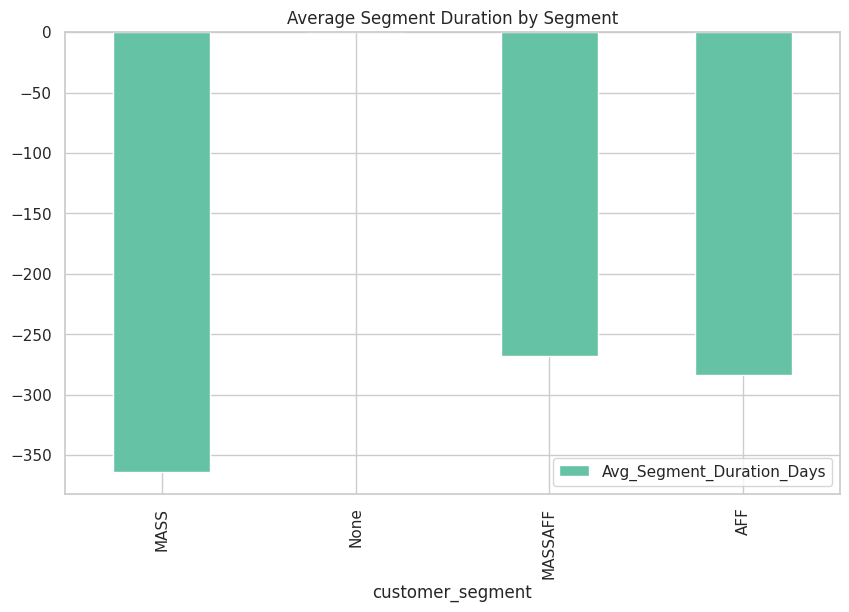

In [77]:
segment_duration_stats_pd = segment_duration_stats.toPandas()

segment_duration_stats_pd.plot(
    x="customer_segment",
    y="Avg_Segment_Duration_Days",
    kind="bar",
    title="Average Segment Duration by Segment",
    figsize=(10, 6)
)

In [78]:
column_types = df.dtypes


categorical_columns = [col[0] for col in column_types if col[1] == 'string']
numerical_columns = [col[0] for col in column_types if col[1] in ['int', 'float', 'double']]


print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['customer_id', 'target_name', 'company_book', 'bucket_abb', 'gender', 'customer_segment', 'business_class_code', 'main_business_class_code', 'churn', 'customer_status', 'lifecycle_stage']
Numerical Columns: ['customer_joining_age', 'customer_age', 'tenure_years']


In [79]:
def bivariate_analysis(dataframe, target, numerical_col, plot_types=["mean_bar", "box", "violin", "hist", "scatter"], hue=None):

    if "mean_bar" in plot_types:
        summary_df = dataframe.groupby(target).agg({numerical_col: "mean"})
        print(f"Mean of {numerical_col} grouped by {target}:")
        print(summary_df)
        print("##########################################")


        summary_df.plot(kind="bar", legend=False, color='skyblue')
        plt.title(f"Mean of {numerical_col} by {target}")
        plt.xlabel(target)
        plt.ylabel(f"Mean of {numerical_col}")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()


    if "box" in plot_types:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=target, y=numerical_col, data=dataframe, palette='Set2')
        plt.title(f"Boxplot of {numerical_col} by {target}")
        plt.show()


    if "violin" in plot_types:
        plt.figure(figsize=(8, 6))
        sns.violinplot(x=target, y=numerical_col, data=dataframe, palette='Set3')
        plt.title(f"Violin Plot of {numerical_col} by {target}")
        plt.show()


    if "hist" in plot_types:
        plt.figure(figsize=(8, 6))
        sns.histplot(dataframe[numerical_col], kde=True, color='purple')
        plt.title(f"Histogram and Density Plot of {numerical_col}")
        plt.xlabel(numerical_col)
        plt.ylabel("Count")
        plt.show()


    if "scatter" in plot_types:
        plt.figure(figsize=(8, 6))
        if hue:
            sns.scatterplot(x=target, y=numerical_col, hue=hue, data=dataframe, palette='coolwarm')
        else:
            sns.scatterplot(x=target, y=numerical_col, data=dataframe, palette='coolwarm')
        plt.title(f"Scatter Plot of {target} vs {numerical_col}")
        plt.show()


In [80]:
age_vs_churn_df = df.select("churn", "customer_age").toPandas()

Mean of customer_age grouped by churn:
       customer_age
churn              
0         43.130983
1         43.512512
##########################################


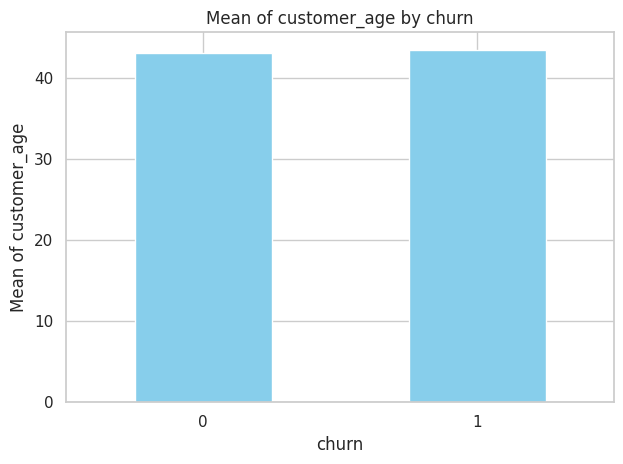

<ipython-input-79-2c1de93c0f3a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_col, data=dataframe, palette='Set2')


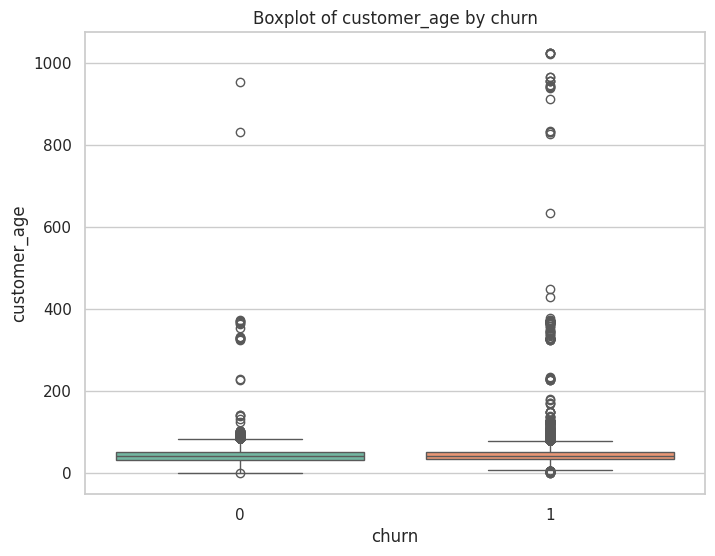

<ipython-input-79-2c1de93c0f3a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target, y=numerical_col, data=dataframe, palette='Set3')


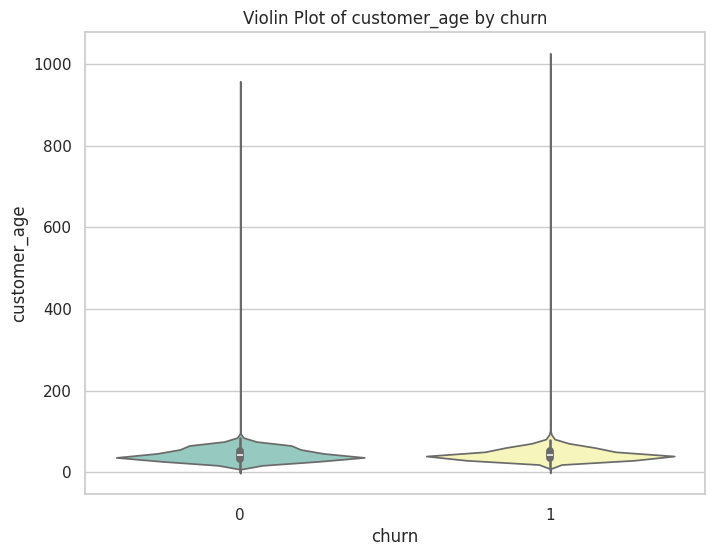

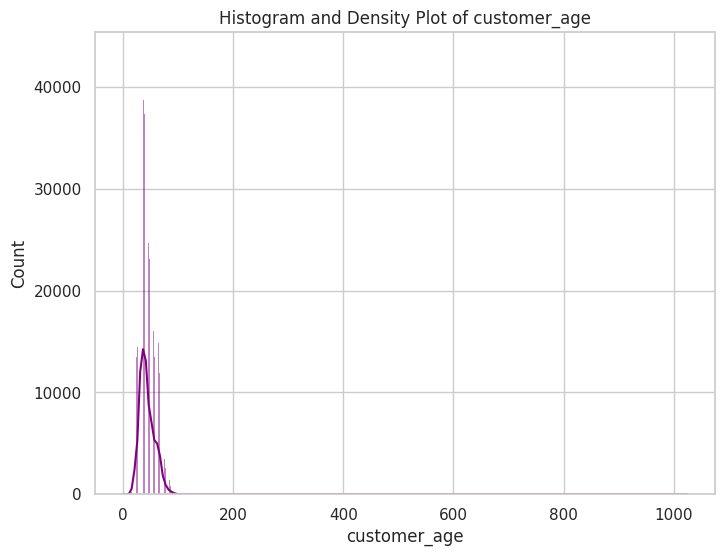

In [81]:
bivariate_analysis(age_vs_churn_df, "churn", "customer_age", plot_types=["mean_bar", "box", "violin", "hist"])

In [82]:
joining_age_vs_churn_df = df.select("churn", "customer_joining_age").toPandas()

Mean of customer_joining_age grouped by churn:
       customer_joining_age
churn                      
0                 38.430246
1                 34.561298
##########################################


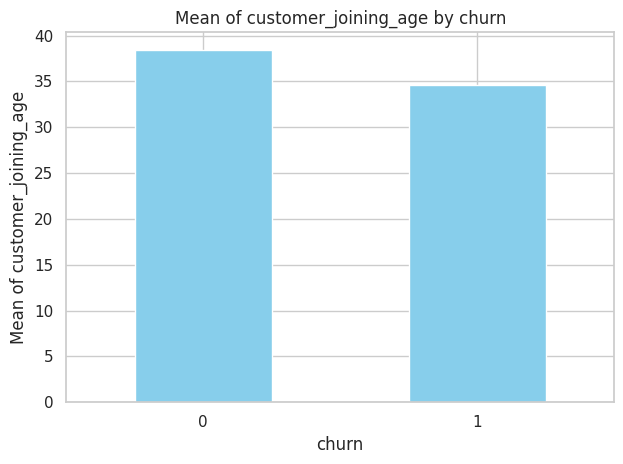

<ipython-input-79-2c1de93c0f3a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_col, data=dataframe, palette='Set2')


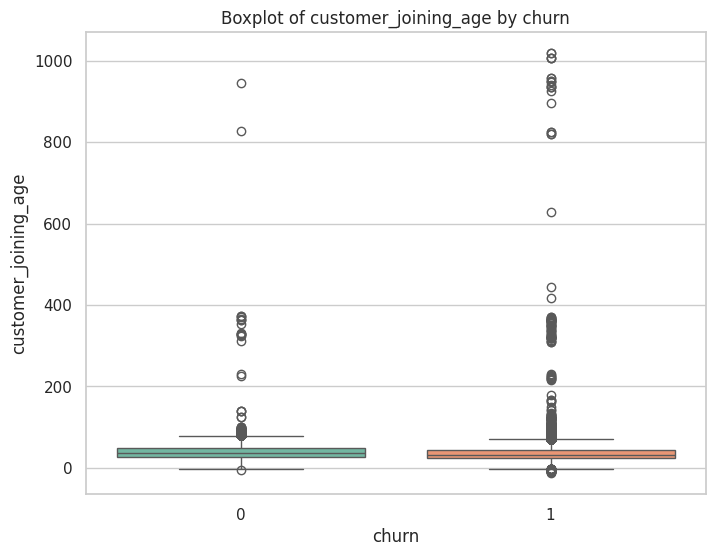

<ipython-input-79-2c1de93c0f3a>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target, y=numerical_col, data=dataframe, palette='Set3')


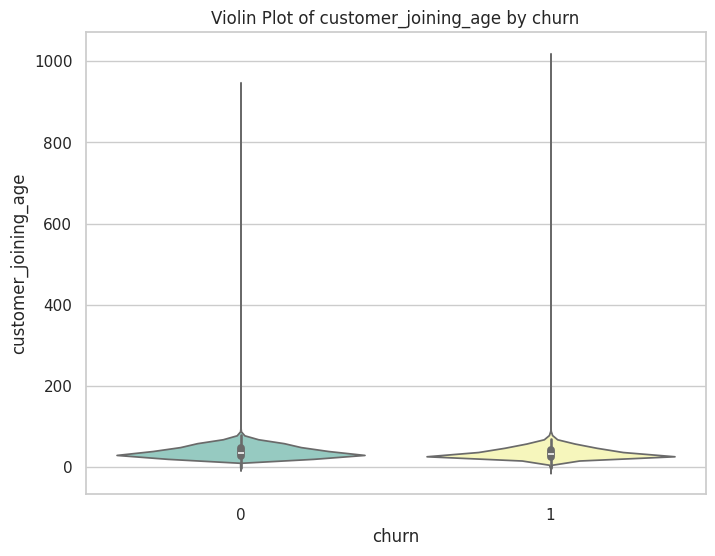

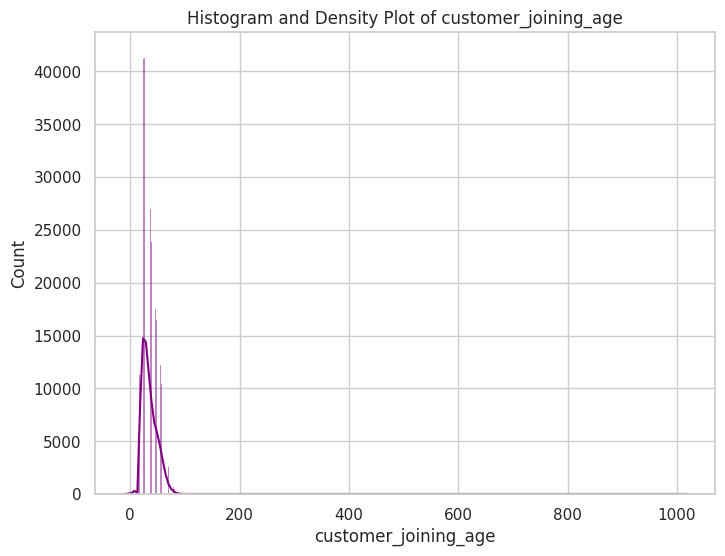

In [83]:
bivariate_analysis(joining_age_vs_churn_df, "churn", "customer_joining_age", plot_types=["mean_bar", "box", "violin", "hist"])

In [84]:
multivariate_df = df.select('customer_joining_age', 'customer_age', 'tenure_years', 'churn').toPandas()

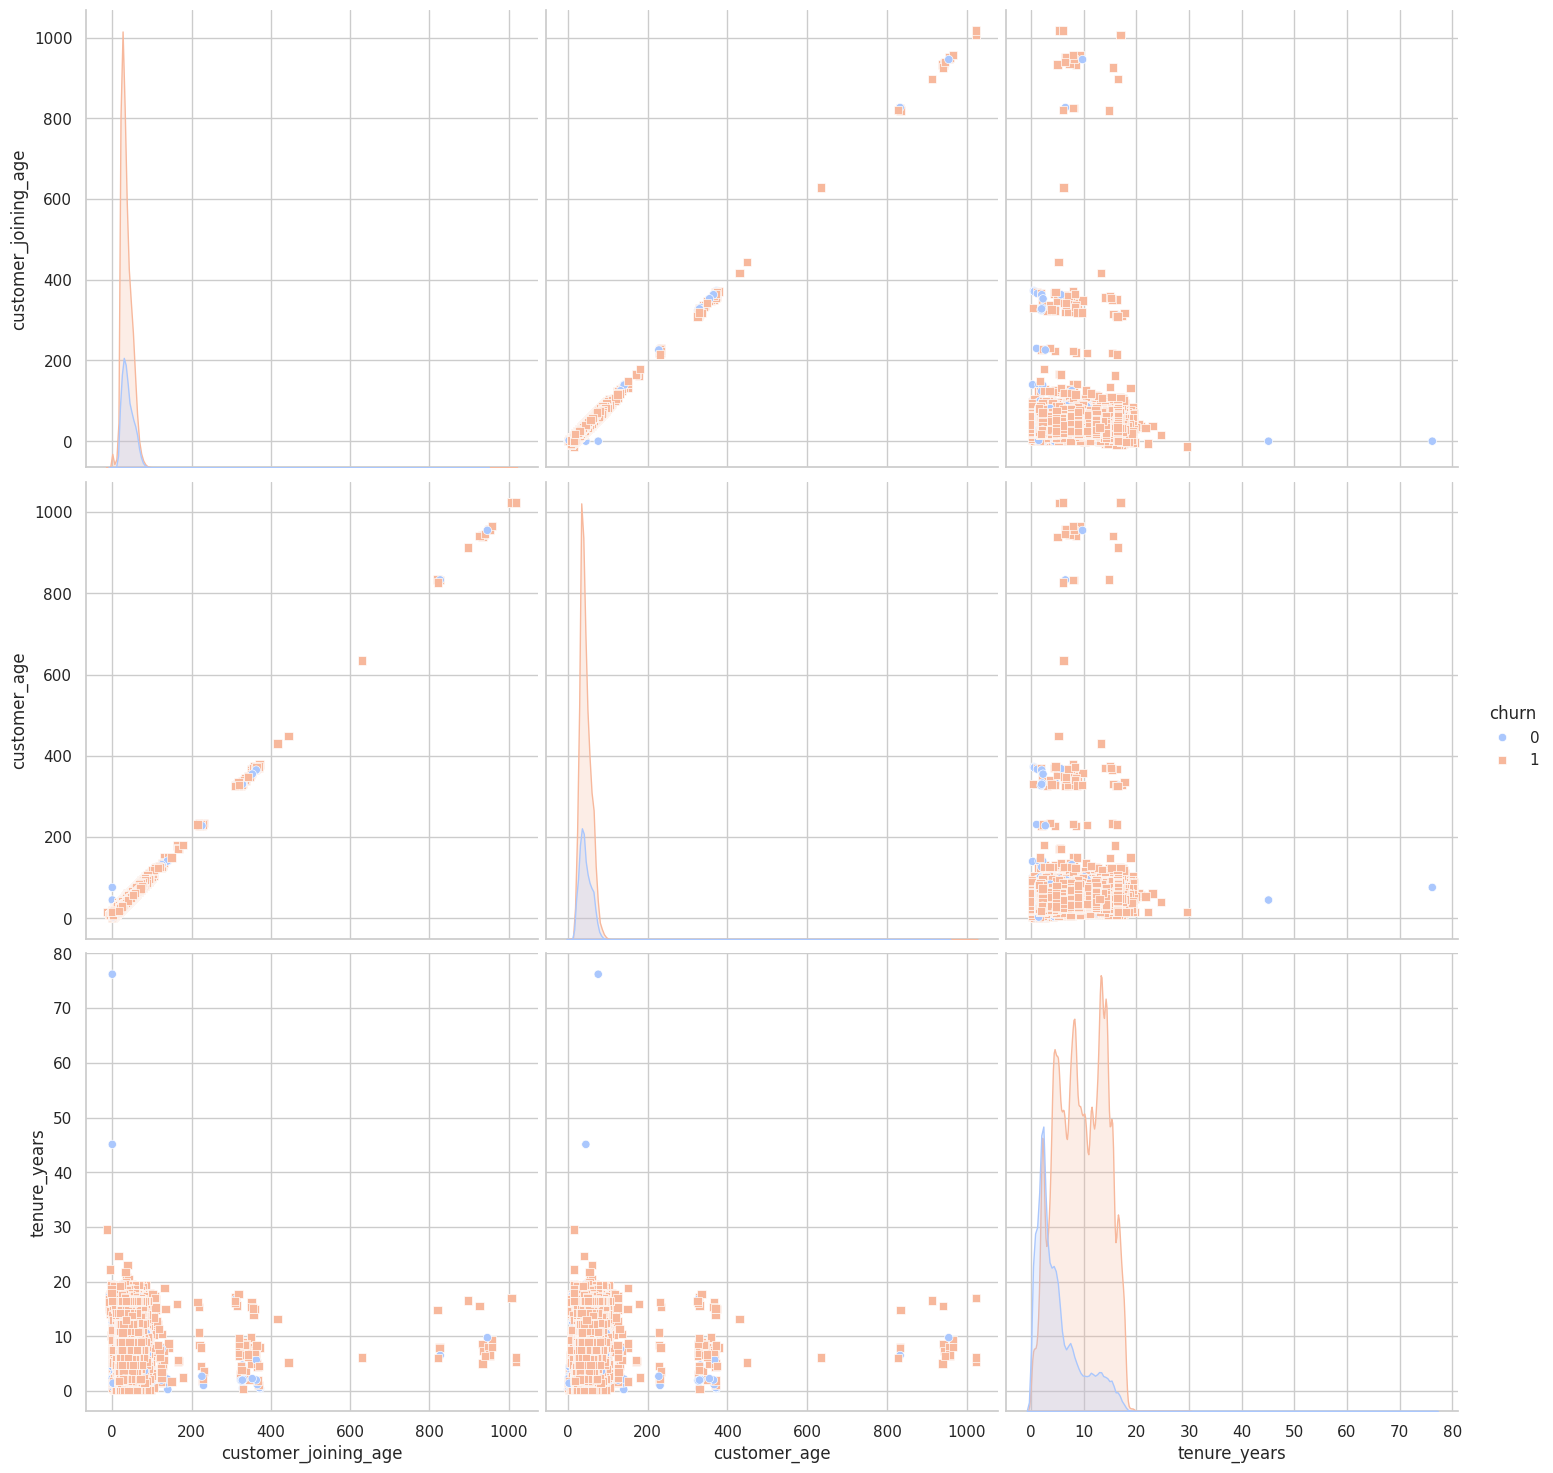

In [85]:
analyze_cols = ['customer_joining_age', 'customer_age', 'tenure_years']

sns.pairplot(data=multivariate_df, vars=analyze_cols, hue="churn", height=5,
             markers=["o", "s"], palette="coolwarm", diag_kind="kde")
plt.show()

In [86]:
df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- customer_open_date: timestamp_ntz (nullable = true)
 |-- target_name: string (nullable = true)
 |-- company_book: string (nullable = true)
 |-- bucket_abb: string (nullable = true)
 |-- customer_joining_age: double (nullable = true)
 |-- marital_status: boolean (nullable = false)
 |-- customer_age: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- customer_start_date: timestamp_ntz (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- record_start_date: timestamp_ntz (nullable = true)
 |-- business_class_code: string (nullable = true)
 |-- main_business_class_code: string (nullable = true)
 |-- contact_date: timestamp_ntz (nullable = true)
 |-- contact_time: timestamp_ntz (nullable = true)
 |-- churn: string (nullable = false)
 |-- customer_status: string (nullable = true)
 |-- segment_start_date: timestamp_ntz (nullable = true)
 |-- segment_end_date: timestamp_ntz (nullable = true)
 |-- tenure_year

In [87]:
from pyspark.sql.functions import col, count, when, countDistinct, unix_timestamp, from_unixtime, lit

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

+-----------+------------------+-----------+------------+----------+--------------------+--------------+------------+------+-------------------+----------------+-----------------+-------------------+------------------------+------------+------------+-----+---------------+------------------+----------------+------------+---------------+
|customer_id|customer_open_date|target_name|company_book|bucket_abb|customer_joining_age|marital_status|customer_age|gender|customer_start_date|customer_segment|record_start_date|business_class_code|main_business_class_code|contact_date|contact_time|churn|customer_status|segment_start_date|segment_end_date|tenure_years|lifecycle_stage|
+-----------+------------------+-----------+------------+----------+--------------------+--------------+------------+------+-------------------+----------------+-----------------+-------------------+------------------------+------------+------------+-----+---------------+------------------+----------------+------------+---

In [88]:
df = df.fillna({"customer_joining_age": df.select(F.mean("customer_joining_age")).collect()[0][0]})

In [89]:
most_frequent_gender = df.groupBy("gender").count().orderBy(F.desc("count")).first()["gender"]

df = df.fillna({"gender": most_frequent_gender})

In [90]:
median_age = df.approxQuantile("customer_age", [0.5], 0.01)[0]

df = df.fillna({"customer_age": median_age})

In [91]:
mode_business_class = df.groupBy("business_class_code").count().orderBy(F.desc("count")).first()["business_class_code"]

df = df.fillna({"business_class_code": mode_business_class})

In [92]:
median_tenure = df.approxQuantile("tenure_years", [0.5], 0.25)[0]

df = df.fillna({"tenure_years": median_tenure})

In [93]:
segment_mode = df.groupBy("customer_segment").count().orderBy("count", ascending=False).first()["customer_segment"]

df = df.fillna({"customer_segment": segment_mode})

In [94]:
from pyspark.sql.functions import datediff, current_date

date_columns = ["customer_open_date", "customer_start_date", "record_start_date",
                "contact_date", "contact_time", "segment_start_date", "segment_end_date"]

for date_col in date_columns:
    if "DATE_TIME" in date_col:
        df = df.withColumn(f"{date_col}_numeric", unix_timestamp(col(date_col)))
    else:
        df = df.withColumn(f"{date_col}_numeric", datediff(current_date(), col(date_col)))

df = df.drop(*date_columns)

In [96]:
df.show(5)

+-----------+---------------+------------+----------+--------------------+--------------+------------+------+----------------+-------------------+------------------------+-----+---------------+------------+---------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+--------------------------+------------------------+
|customer_id|    target_name|company_book|bucket_abb|customer_joining_age|marital_status|customer_age|gender|customer_segment|business_class_code|main_business_class_code|churn|customer_status|tenure_years|lifecycle_stage|customer_open_date_numeric|customer_start_date_numeric|record_start_date_numeric|contact_date_numeric|contact_time_numeric|segment_start_date_numeric|segment_end_date_numeric|
+-----------+---------------+------------+----------+--------------------+--------------+------------+------+----------------+-------------------+------------------------+-----+---------------+-----------

In [97]:
numeric_date_columns = [
    "customer_open_date_numeric",
    "customer_start_date_numeric",
    "record_start_date_numeric",
    "contact_date_numeric",
    "contact_time_numeric",
    "segment_start_date_numeric",
    "segment_end_date_numeric",
]

for col_name in numeric_date_columns:
    mean_value = df.select(mean(col_name)).first()[0]
    df = df.fillna({col_name: mean_value})

In [100]:
from pyspark.sql.functions import col, count, when, countDistinct, unix_timestamp, from_unixtime, lit

missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()

+-----------+-----------+------------+----------+--------------------+--------------+------------+------+----------------+-------------------+-----+---------------+------------+---------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+--------------------------+------------------------+
|customer_id|target_name|company_book|bucket_abb|customer_joining_age|marital_status|customer_age|gender|customer_segment|business_class_code|churn|customer_status|tenure_years|lifecycle_stage|customer_open_date_numeric|customer_start_date_numeric|record_start_date_numeric|contact_date_numeric|contact_time_numeric|segment_start_date_numeric|segment_end_date_numeric|
+-----------+-----------+------------+----------+--------------------+--------------+------------+------+----------------+-------------------+-----+---------------+------------+---------------+--------------------------+---------------------------+--------------

In [104]:
df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- target_name: string (nullable = true)
 |-- company_book: string (nullable = true)
 |-- bucket_abb: string (nullable = true)
 |-- customer_joining_age: double (nullable = false)
 |-- marital_status: boolean (nullable = false)
 |-- customer_age: double (nullable = false)
 |-- gender: string (nullable = false)
 |-- customer_segment: string (nullable = false)
 |-- business_class_code: string (nullable = false)
 |-- churn: string (nullable = false)
 |-- customer_status: string (nullable = true)
 |-- tenure_years: double (nullable = false)
 |-- lifecycle_stage: string (nullable = false)
 |-- customer_open_date_numeric: integer (nullable = true)
 |-- customer_start_date_numeric: integer (nullable = true)
 |-- record_start_date_numeric: integer (nullable = true)
 |-- contact_date_numeric: integer (nullable = true)
 |-- contact_time_numeric: integer (nullable = true)
 |-- segment_start_date_numeric: integer (nullable = true)
 |-- segment_end_

In [111]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

categorical_columns = [
    "target_name", "customer_segment", "business_class_code", "gender", "lifecycle_stage", "customer_status"
]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_columns]


encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in categorical_columns]


pipeline = Pipeline(stages=indexers + encoders)


df_transformed = pipeline.fit(df).transform(df)


encoded_columns = [f"{col}_encoded" for col in categorical_columns]
numeric_columns = [
    "customer_joining_age", "marital_status", "customer_age",
    "tenure_years", "customer_open_date_numeric", "customer_start_date_numeric",
    "record_start_date_numeric", "contact_date_numeric", "contact_time_numeric",
    "segment_start_date_numeric", "segment_end_date_numeric"
]
final_columns = encoded_columns + numeric_columns + ["churn"]


df_final = df_transformed.select(*final_columns)


df_final.show()

+-------------------+------------------------+---------------------------+--------------+-----------------------+-----------------------+--------------------+--------------+------------+------------+--------------------------+---------------------------+-------------------------+--------------------+--------------------+--------------------------+------------------------+-----+
|target_name_encoded|customer_segment_encoded|business_class_code_encoded|gender_encoded|lifecycle_stage_encoded|customer_status_encoded|customer_joining_age|marital_status|customer_age|tenure_years|customer_open_date_numeric|customer_start_date_numeric|record_start_date_numeric|contact_date_numeric|contact_time_numeric|segment_start_date_numeric|segment_end_date_numeric|churn|
+-------------------+------------------------+---------------------------+--------------+-----------------------+-----------------------+--------------------+--------------+------------+------------+--------------------------+------------

In [112]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

all_features = [
    "customer_joining_age", "customer_age", "tenure_years",
    "customer_open_date_numeric", "customer_start_date_numeric",
    "record_start_date_numeric", "contact_date_numeric",
    "contact_time_numeric", "segment_start_date_numeric",
    "segment_end_date_numeric",
    "target_name_encoded", "customer_segment_encoded", "business_class_code_encoded"
]

assembler = VectorAssembler(inputCols=all_features, outputCol="all_features")

scaler = StandardScaler(inputCol="all_features", outputCol="scaled_features", withMean=True, withStd=True)

pipeline = Pipeline(stages=[assembler, scaler])
scaled_model = pipeline.fit(df_final)
df_scaled = scaled_model.transform(df_final)

final_scaled_df = df_scaled.select("churn", "scaled_features")

final_scaled_df.show(truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|churn|scaled_features                                                                                                                                                                                                                 

In [114]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
import xgboost as xgb

assembler = VectorAssembler(inputCols=["scaled_features"], outputCol="features")
df_ml = assembler.transform(final_scaled_df).select("features", "churn")

df_ml = df_ml.withColumn("churn", df_ml["churn"].cast("int"))

train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(labelCol="churn", featuresCol="features")
rf = RandomForestClassifier(labelCol="churn", featuresCol="features", seed=42)

train_pd = train_data.toPandas()
test_pd = test_data.toPandas()
xgb_model = xgb.XGBClassifier()

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="churn", metricName="areaUnderROC")

lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       numFolds=3)


rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       numFolds=3)


lr_model = lr_cv.fit(train_data)
rf_model = rf_cv.fit(train_data)


x_train = np.array([row['features'].toArray() for row in train_pd.to_dict('records')])
y_train = train_pd["churn"].values
xgb_model.fit(x_train, y_train)



lr_predictions = lr_model.transform(test_data)
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc}")


rf_predictions = rf_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")


x_test = np.array([row['features'].toArray() for row in test_pd.to_dict('records')])
y_test = test_pd["churn"].values
xgb_auc = xgb_model.score(x_test, y_test)
print(f"XGBoost AUC: {xgb_auc}")


Logistic Regression AUC: 0.9244053744808727
Random Forest AUC: 0.9743251490857527
XGBoost AUC: 0.9422113976223728


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.80      0.62      0.70     55145
           1       0.89      0.95      0.92    179711

    accuracy                           0.87    234856
   macro avg       0.84      0.79      0.81    234856
weighted avg       0.87      0.87      0.87    234856



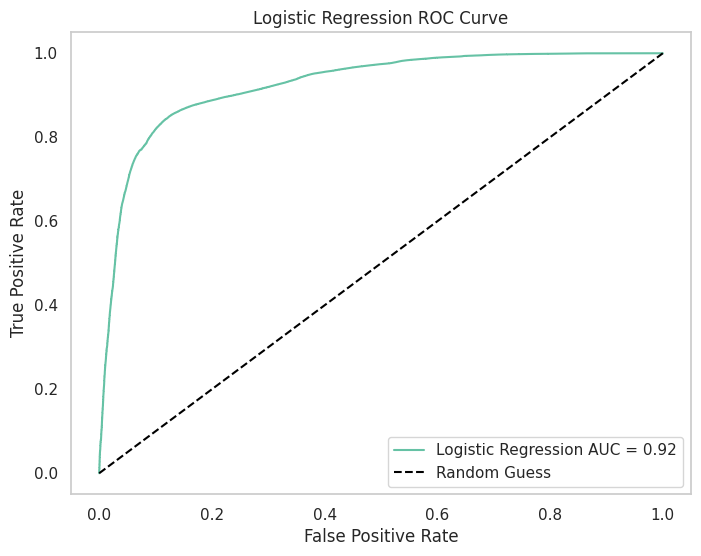

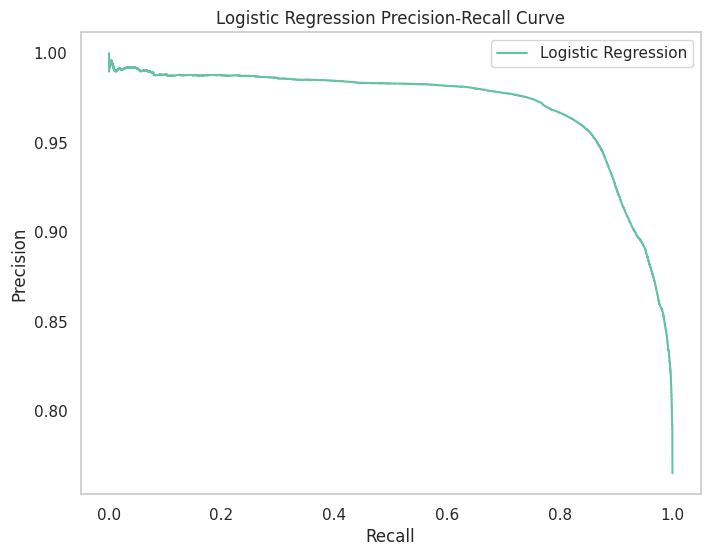

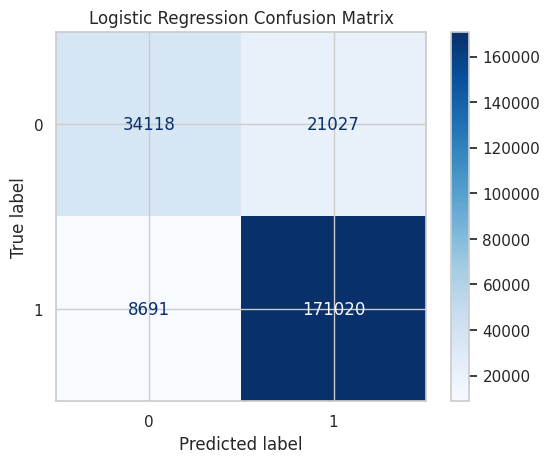

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.81      0.91      0.86     55145
           1       0.97      0.94      0.95    179711

    accuracy                           0.93    234856
   macro avg       0.89      0.92      0.91    234856
weighted avg       0.93      0.93      0.93    234856



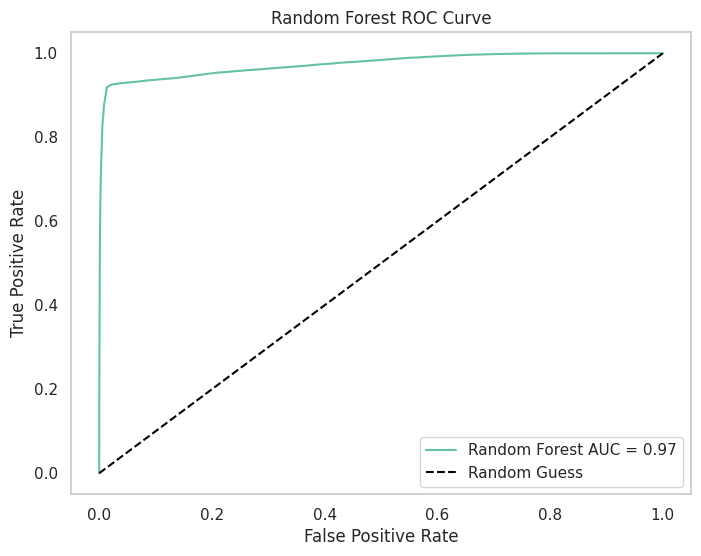

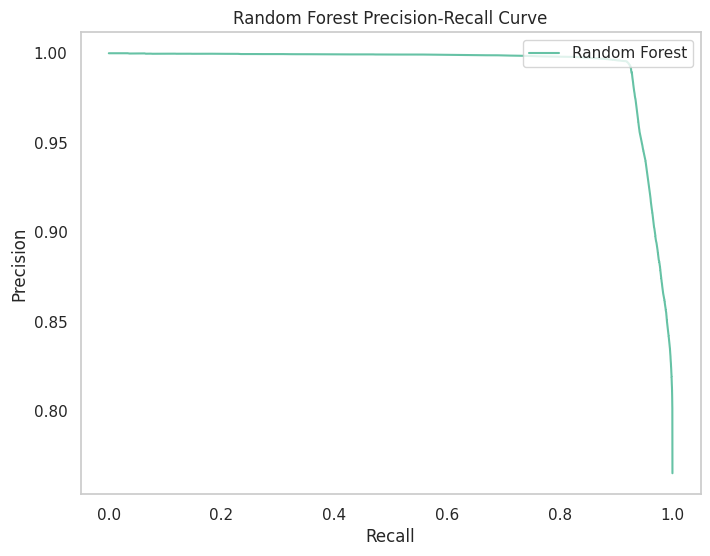

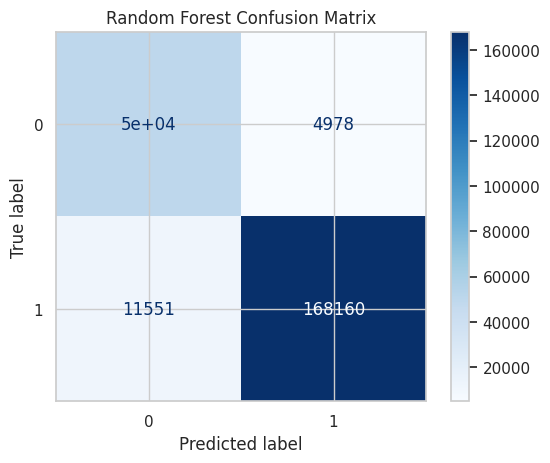

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     55145
           1       0.99      0.93      0.96    179711

    accuracy                           0.94    234856
   macro avg       0.90      0.95      0.92    234856
weighted avg       0.95      0.94      0.94    234856



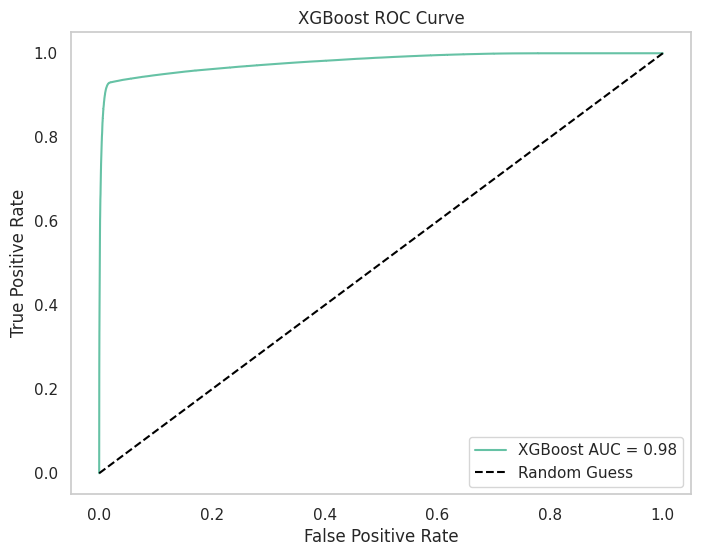

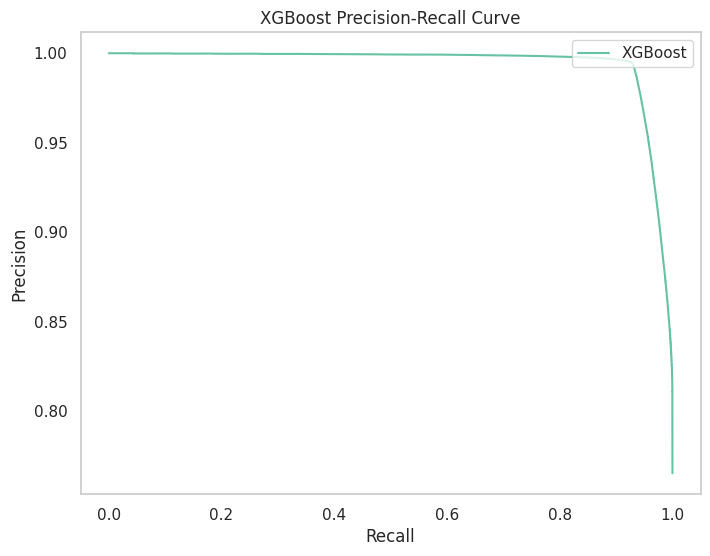

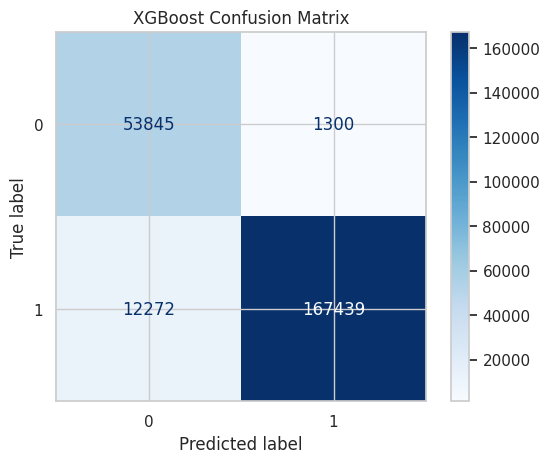

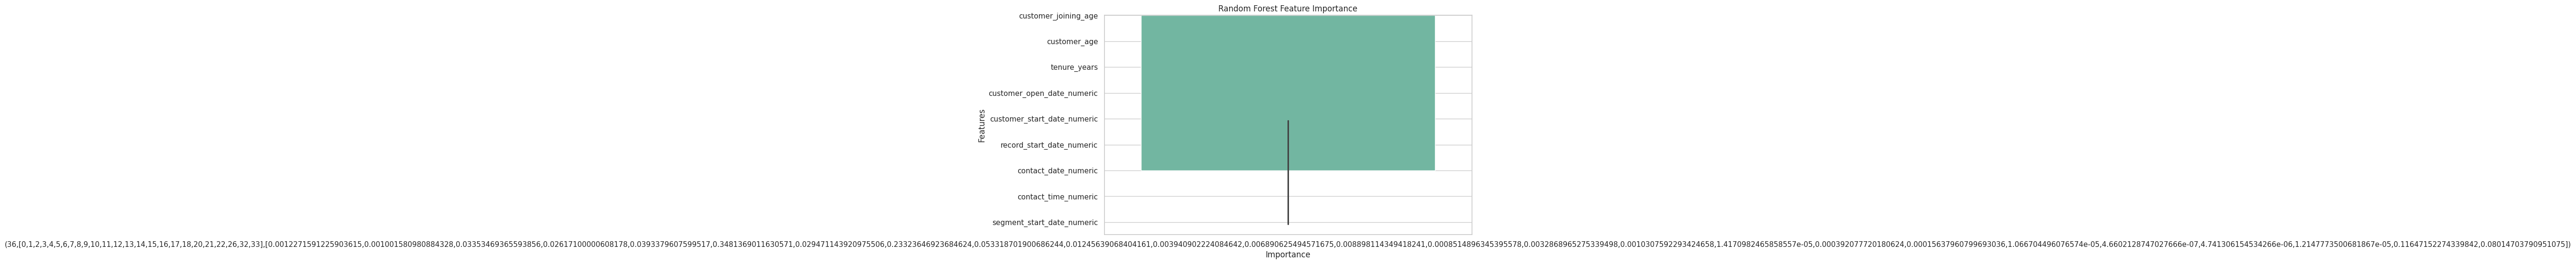

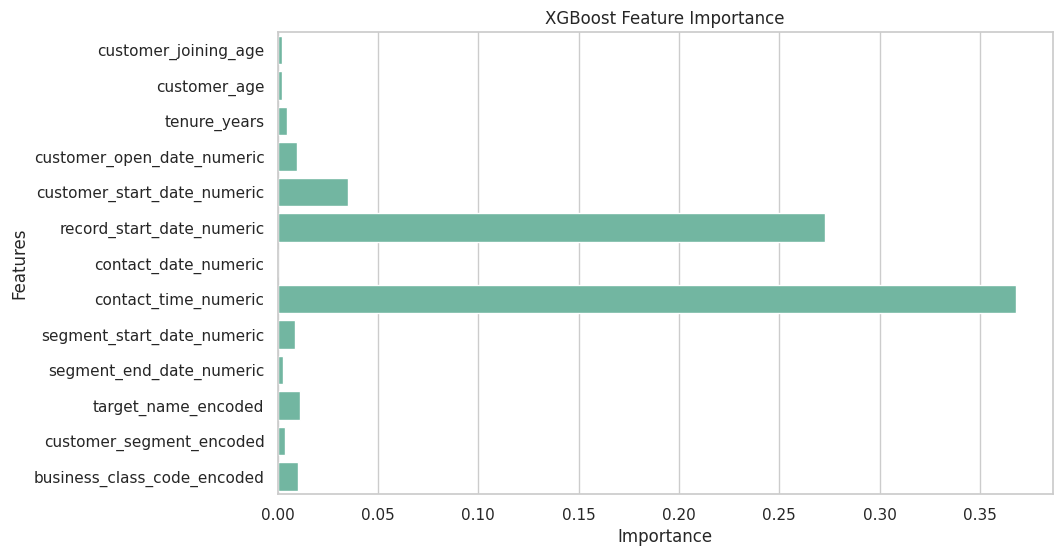

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    classification_report,
    ConfusionMatrixDisplay,
)
import seaborn as sns


lr_predictions_pd = lr_predictions.select("churn", "probability").toPandas()
lr_y_true = lr_predictions_pd["churn"]
lr_y_prob = lr_predictions_pd["probability"].apply(lambda x: x[1])

rf_predictions_pd = rf_predictions.select("churn", "probability").toPandas()
rf_y_true = rf_predictions_pd["churn"]
rf_y_prob = rf_predictions_pd["probability"].apply(lambda x: x[1])


xgb_y_prob = xgb_model.predict_proba(x_test)[:, 1]

def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

def plot_precision_recall_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name}")
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

print("Logistic Regression Classification Report")
print(classification_report(lr_y_true, lr_y_prob > 0.5))
plot_roc_curve(lr_y_true, lr_y_prob, "Logistic Regression")
plot_precision_recall_curve(lr_y_true, lr_y_prob, "Logistic Regression")
plot_confusion_matrix(lr_y_true, lr_y_prob > 0.5, "Logistic Regression")

print("Random Forest Classification Report")
print(classification_report(rf_y_true, rf_y_prob > 0.5))
plot_roc_curve(rf_y_true, rf_y_prob, "Random Forest")
plot_precision_recall_curve(rf_y_true, rf_y_prob, "Random Forest")
plot_confusion_matrix(rf_y_true, rf_y_prob > 0.5, "Random Forest")







print("XGBoost Classification Report")
print(classification_report(y_test, xgb_y_prob > 0.5))
plot_roc_curve(y_test, xgb_y_prob, "XGBoost")
plot_precision_recall_curve(y_test, xgb_y_prob, "XGBoost")
plot_confusion_matrix(y_test, xgb_y_prob > 0.5, "XGBoost")

rf_feature_importance = rf_model.bestModel.featureImportances
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_feature_importance, y=all_features)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

xgb_feature_importance = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
xgb_feature_names = scaled_model.stages[0].getInputCols()

xgb_feature_importance = xgb_feature_importance[:len(xgb_feature_names)]
sns.barplot(x=xgb_feature_importance, y=all_features)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()
